# learnkQ, reaction split, CM features, minmax scaling

In [1]:
import pandas as pd
import surfreact.mlutils as mlut
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import joblib

import molml.molecule
import reaxnet.io.molml
import surfreact.utils as ut


from sklearn.gaussian_process.kernels import PairwiseKernel, Matern

## 1. Load data


In [3]:
MLdataset = mlut.load_MLdataset('../../../data/MLdataset/')

In [4]:
MLdataset = MLdataset.sort_values('reaction_id').reset_index(drop = True)

## 2. Compute features for atoms

Here we are selecting the 6 atoms that move the most during the reaction, then computing geometry features for them.

In [7]:
react_selected_list = []
prod_selected_list = []

for i, row in MLdataset.iterrows():
    
    print(row.reaction_id)
    
    react = row.reactant_geom
    prod = row.product_geom
    
    react_selected, prod_selected = mlut.get_moving_atoms(react, prod, 6)
    print(react_selected.get_chemical_symbols())
    react_selected_list.append(react_selected)
    prod_selected_list.append(prod_selected)

4105
[171 170 147 143 142 146]
['H', 'C', 'Rh', 'Rh', 'Rh', 'Rh']
4119
[36 38 37 28 30 31]
['H', 'O', 'C', 'Rh', 'Rh', 'Rh']
4127
[162 164 161 163 135 125]
['H', 'O', 'H', 'C', 'Rh', 'Rh']
4128
[99 98 96 97 81 84]
['H', 'H', 'C', 'H', 'Rh', 'Rh']
82687
[174 173 172 170 171 144]
['H', 'H', 'H', 'O', 'C', 'Pt']
82736
[171 170 172 148 150 149]
['H', 'C', 'H', 'Ir', 'Ir', 'Ir']
82754
[173 170 172 171 121 124]
['H', 'C', 'H', 'H', 'Ir', 'Ir']
82755
[173 170 172 171 121 122]
['H', 'C', 'H', 'H', 'Pt', 'Pt']
82769
[171 173 170 172 147 143]
['H', 'O', 'H', 'C', 'Ag', 'Ag']
82826
[171 173 172 170 148 150]
['H', 'O', 'C', 'H', 'Ir', 'Ir']
82843
[170 172 171 151 149 148]
['H', 'O', 'C', 'Pd', 'Pd', 'Pd']
432820
[30 27 29 28 25 22]
['H', 'C', 'H', 'O', 'Cu', 'Cu']
432827
[29 28 27 22 19 25]
['H', 'O', 'C', 'Cu', 'Cu', 'Cu']
432887
[29 28 27 19 18 25]
['H', 'H', 'C', 'Cu', 'Cu', 'Cu']


In [8]:
MLdataset['selected_reactant_atoms'] = react_selected_list
MLdataset['selected_product_atoms'] = prod_selected_list


#### Compute coulomb matrix features for selected atoms

In [9]:
reactants = []
products = []

for i, row in MLdataset.iterrows():
    reactants.append(row.selected_reactant_atoms)
    products.append(row.selected_product_atoms)
    

In [10]:
allgeoms = reactants + products

In [11]:
CM_input = [reaxnet.io.molml.atoms_to_molmllist(geom) for geom in allgeoms]

In [12]:
feat = molml.molecule.CoulombMatrix()

features = feat.fit_transform(CM_input)

In [13]:
reactant_feats = features[0:int(len(features)/2)]
product_feats = features[int(len(features)/2):]

CM_diff = [react - prod for prod, react in zip(product_feats, reactant_feats)]

In [14]:
geom_features = np.zeros((len(MLdataset), 36))

In [15]:
for i, feat in enumerate(CM_diff):
    geom_features[i,:] = feat

## 3. Combine features into one matrix

In [17]:
X, y  = mlut.concatenate_features_kQ(geom_features, MLdataset, log_cff=True)

In [18]:
X.shape

(55, 39)

## 4. Train/test split

In [20]:
test_index = [4119, 82754, 82755, 432820]

In [21]:
X_train_indexed, X_test_indexed, y_train, y_test = mlut.reaction_split(X, y, test_index)

In [22]:
X_train = X_train_indexed[:, 1:]
X_test = X_test_indexed[:, 1:]

## 5. Scale CM values and other features

In [23]:
scaler = sklearn.preprocessing.MinMaxScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## 6. Train a  GPRs

In [24]:
LS = 1
scale_min = 1e-5
scale_max = 1e5
Nr = 50
RS = 27

In [25]:
kernel = 1 * Matern(length_scale=LS, length_scale_bounds=(scale_min, scale_max)) + 1 * PairwiseKernel()

gpr = sklearn.gaussian_process.GaussianProcessRegressor(kernel = kernel, normalize_y = False, n_restarts_optimizer=Nr, random_state=RS)

gpr.fit(X_train, y_train)

/Users/bgpelkie/miniconda3/envs/cfflearning/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/bgpelkie/miniconda3/envs/cfflearning/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=1, nu=1.5) + 1**2 * PairwiseKernel(gamma=1.0, metric=linear),
                         n_restarts_optimizer=50, random_state=27)

## 7. Evalute model 

In [26]:
y_pred_train = gpr.predict(X_train)
train_MAE = sklearn.metrics.mean_absolute_error(y_train, y_pred_train)
MAPE_train = sklearn.metrics.mean_absolute_percentage_error(y_train, y_pred_train)*100
print(MAPE_train)
print(train_MAE)

1.434531053179242e-09
6.750959449583696e-10


In [27]:
y_pred, y_pred_std = gpr.predict(X_test, return_std=True)

In [35]:
MAE = sklearn.metrics.mean_absolute_error(y_test, y_pred)
r2 = sklearn.metrics.r2_score(y_test, y_pred)
MAPE = sklearn.metrics.mean_absolute_percentage_error(y_test, y_pred)*100

print('MAE: ', MAE)
print('R2: ', r2)
print('MAPE (Table 2): ', MAPE)

MAE:  13.98392593824318
R2:  -4.647573441057898
MAPE (Table 2):  32.140832187582895


Text(0.5, 1.0, 'Reaction Split Test Prediction Parity Plot')

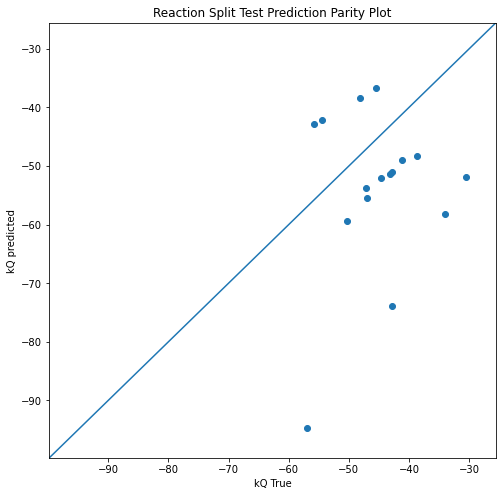

In [34]:
fig, ax = plt.subplots(figsize = (8,8))

lowlim = min(min(y_pred), min(y_test))-5
hilim = max(max(y_pred), max(y_test))+5

#lowlim = min(y_test)
#hilim = max(y_test)

ax.set_xlim(lowlim, hilim)
ax.set_ylim(lowlim, hilim)
line = np.linspace(lowlim, hilim, 1000)

ax.plot(line, line)
plt.scatter(y_test, y_pred)
ax.set_xlabel('kQ True')
ax.set_ylabel('kQ predicted')
ax.set_title('Reaction Split Test Prediction Parity Plot')